## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from IPython.display import Audio
import resampy

## Extract Data

In [4]:
path = "kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24"

In [5]:
#happens sometimes 
#if '.DS_Store' in os.listdir("data"):
#    os.remove('data/.DS_Store')

    
#extract file values 
directory_list = os.listdir(path)

file_emotion = []
file_path = []
file_gender = []
file_intensity = []
file_line = []


for dir in directory_list:
    
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(os.path.join(path,dir))
    
    for file in actor:
        part = file.split('.')
        part = part[0].split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_intensity.append(0 if int(part[3]) == 1 else 1) #0 is normal and 1 is strong
        file_line.append("Kids are talking by the door" if int(part[4]) == 1 else "Dogs are sitting by the door")
        file_path.append(os.path.join(path,dir,file))
        file_gender.append(0 if int(dir.split('_')[1]) %2 == 1 else 1) #0 is male and 1 is female
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for gender of actor
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

#dataframe for emotional intensity
intensity_df = pd.DataFrame(file_intensity, columns=['Intensity'])

#dataframe for sentences spoken
line_df = pd.DataFrame(file_line, columns=['Line'])


#main df
df = pd.concat([path_df, emotion_df, gender_df, intensity_df, line_df], axis=1)

# changing integers to actual emotions.
df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
df.to_csv("data_clean.csv")

df.head()

Path Emotions  Gender  \
0  kaggle/input/ravdess-emotional-speech-audio/au...    angry       1   
1  kaggle/input/ravdess-emotional-speech-audio/au...     fear       1   
2  kaggle/input/ravdess-emotional-speech-audio/au...     fear       1   
3  kaggle/input/ravdess-emotional-speech-audio/au...    angry       1   
4  kaggle/input/ravdess-emotional-speech-audio/au...  disgust       1   

   Intensity                          Line  
0          0  Dogs are sitting by the door  
1          0  Dogs are sitting by the door  
2          1  Kids are talking by the door  
3          1  Kids are talking by the door  
4          0  Kids are talking by the door

### Read file
Use `head` and `tail` to retrieve the top and bottom `n` rows. Use `sample` to randomly view `5` rows

In [ ]:
df = pd.read_csv("data_clean.csv")
df.head()

In [ ]:
df.tail()

In [ ]:
df.sample(5)

In [ ]:
df.isna().sum()

Unnamed: 0    0
Path          0
Emotions      0
Gender        0
Intensity     0
Line          0
dtype: int64

### Summary Statistics

In [ ]:
df[["Gender","Intensity","Emotions"]].describe(include="all")

Gender    Intensity  Emotions
count   1440.000000  1440.000000      1440
unique          NaN          NaN         8
top             NaN          NaN  surprise
freq            NaN          NaN       192
mean       0.500000     0.466667       NaN
std        0.500174     0.499061       NaN
min        0.000000     0.000000       NaN
25%        0.000000     0.000000       NaN
50%        0.500000     0.000000       NaN
75%        1.000000     1.000000       NaN
max        1.000000     1.000000       NaN

### Data distribution

<Axes: xlabel='Emotions'>

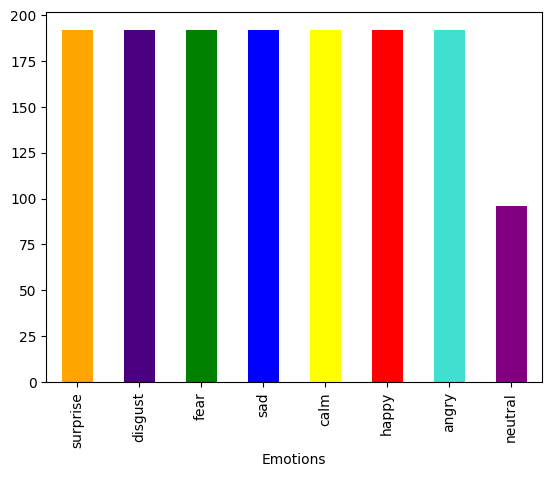

In [ ]:
df["Emotions"].value_counts().plot(kind='bar',color={'red','blue','green','orange','yellow','purple','indigo','turquoise'})

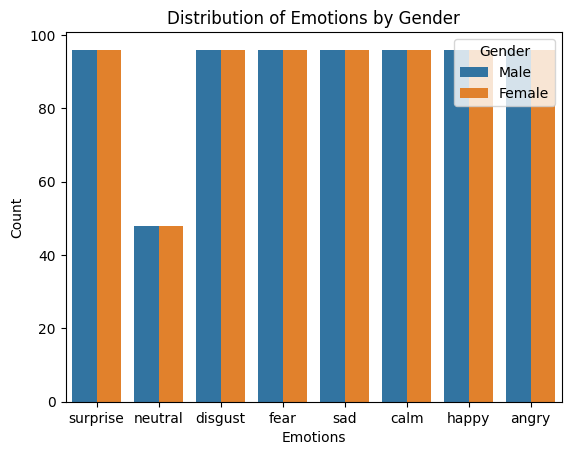

Emotions  Gender  Intensity
angry     0       0            48
                  1            48
surprise  1       0            48
          0       1            48
                  0            48
sad       1       1            48
                  0            48
          0       1            48
                  0            48
neutral   1       0            48
          0       0            48
happy     1       1            48
                  0            48
          0       1            48
                  0            48
fear      1       1            48
                  0            48
          0       1            48
                  0            48
disgust   1       1            48
                  0            48
          0       1            48
                  0            48
calm      1       1            48
                  0            48
          0       1            48
                  0            48
angry     1       1            48
                  0 

In [ ]:
sns.countplot(x='Emotions', hue='Gender', data=df) #ax
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions by Gender')
plt.legend(title='Gender', loc='upper right', labels=['Male','Female'])  
plt.show()

# Display count values on top of the bars
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')


df[['Emotions', 'Gender', 'Intensity']].value_counts()
# df['Line'].value_counts()

Data is evenly distributed except "Neutral" emotion has half the number of samples as there is no "Strong" emotional intensity for "Neutral" 

### View Waveforms

In [ ]:
#helper functions
def create_waveform(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Amplitude waveform for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
        

def create_spectrogram(data, sr, e): #use mel-spectro instead?
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram (Pitch) for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log') #log is better for differentiating - mel-spectrogram
    plt.colorbar()
        

#df is global variable
def show(emotion):
    path = np.array(df.Path[df.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveform(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))

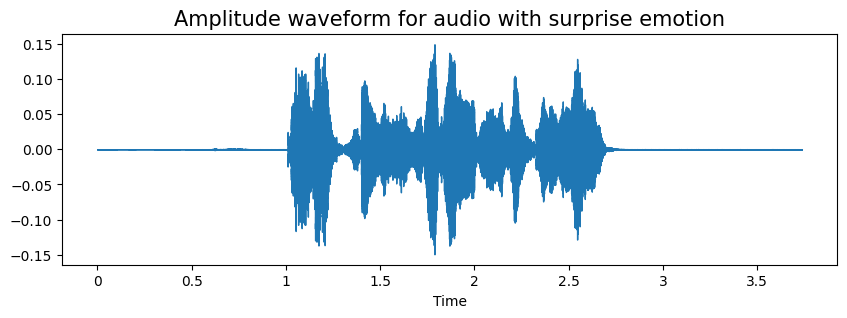

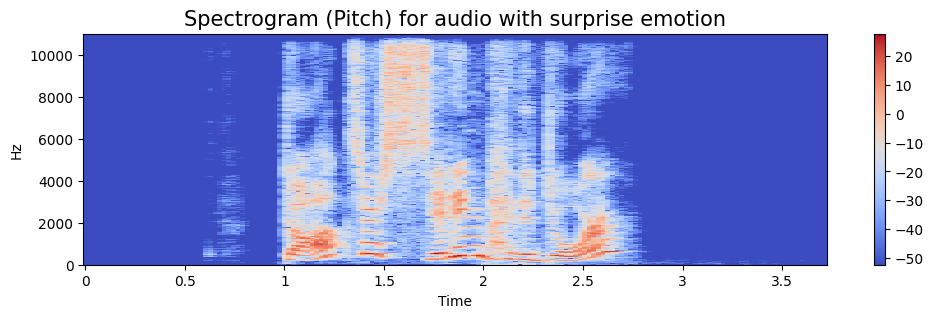

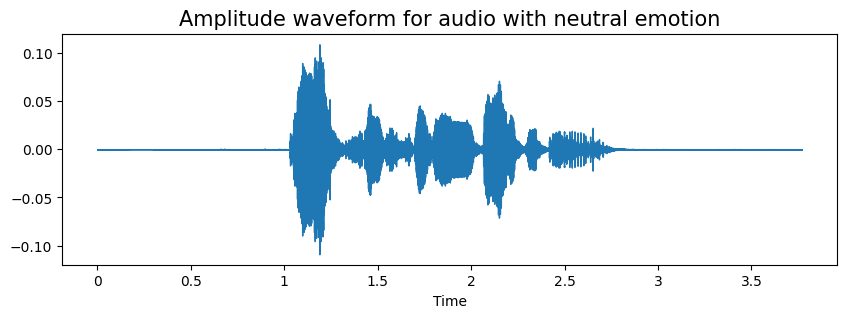

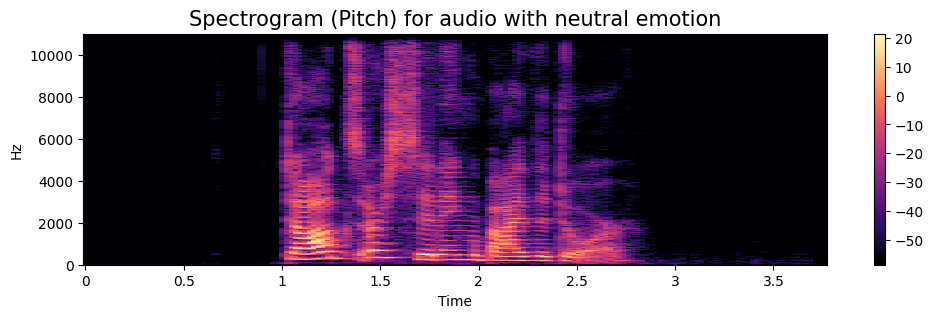

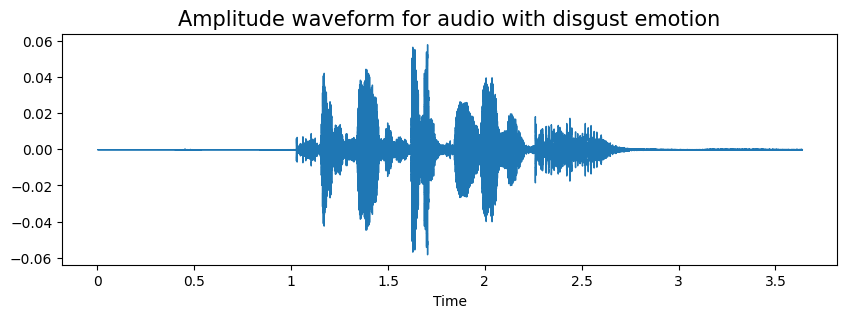

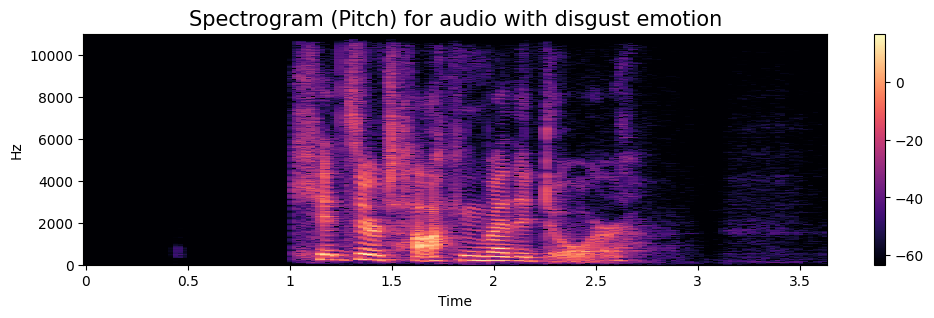

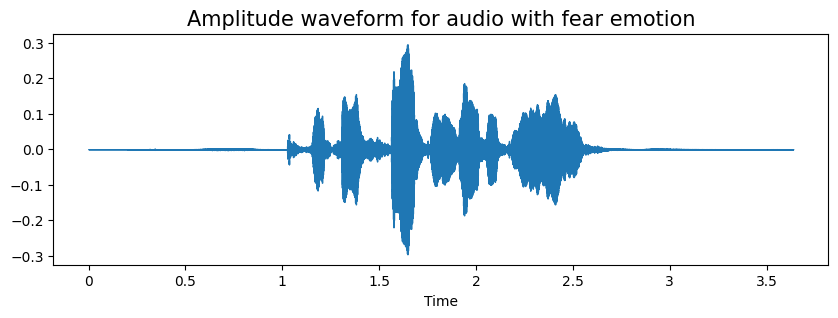

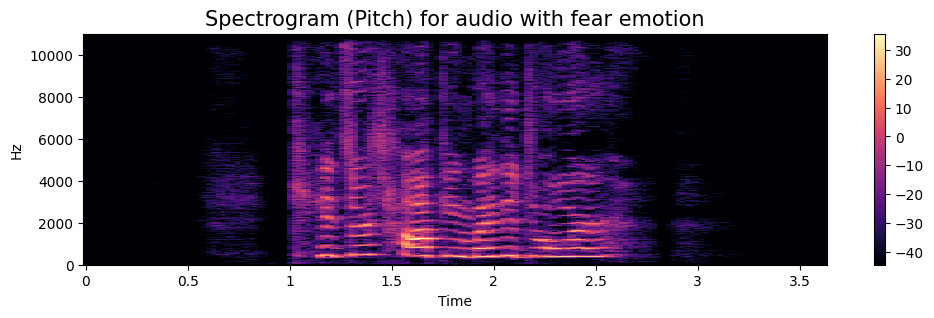

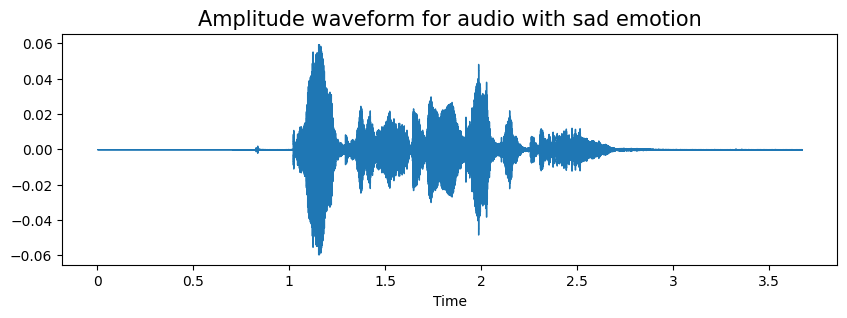

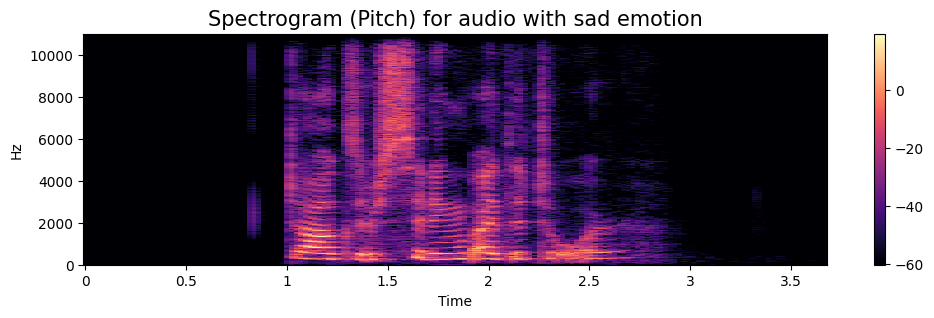

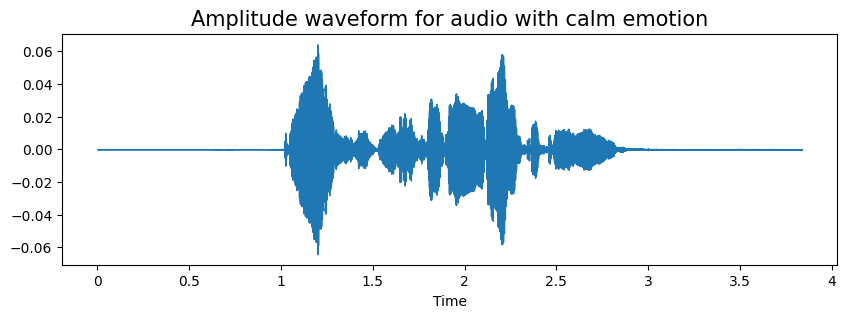

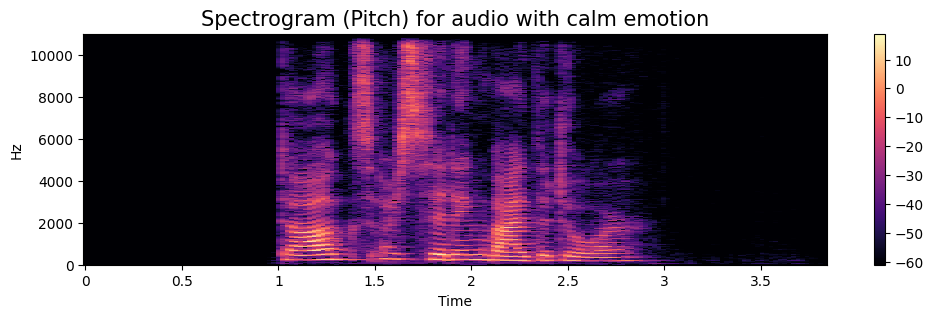

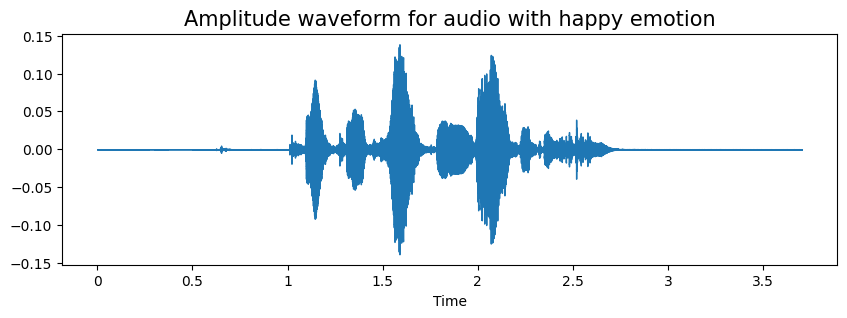

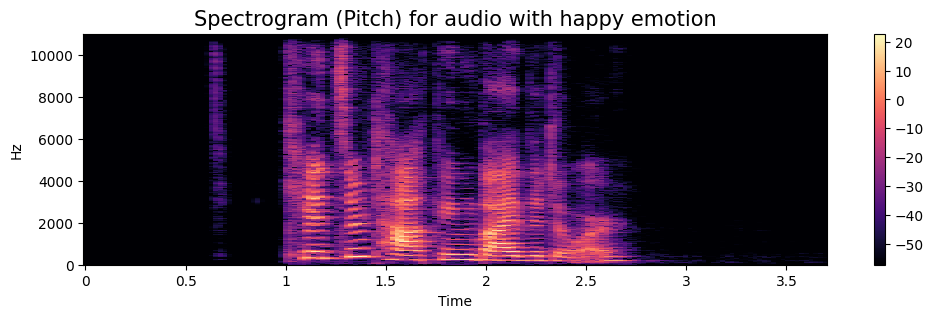

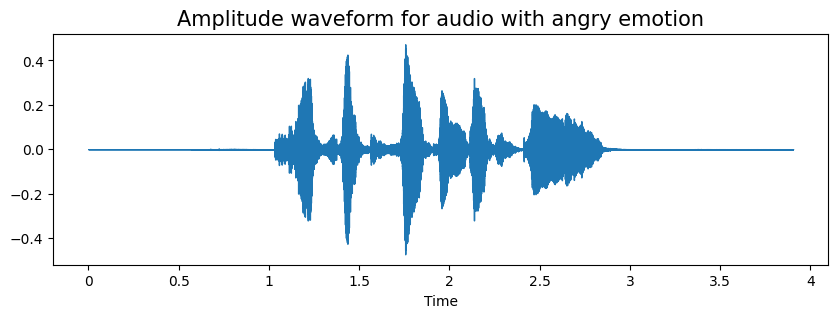

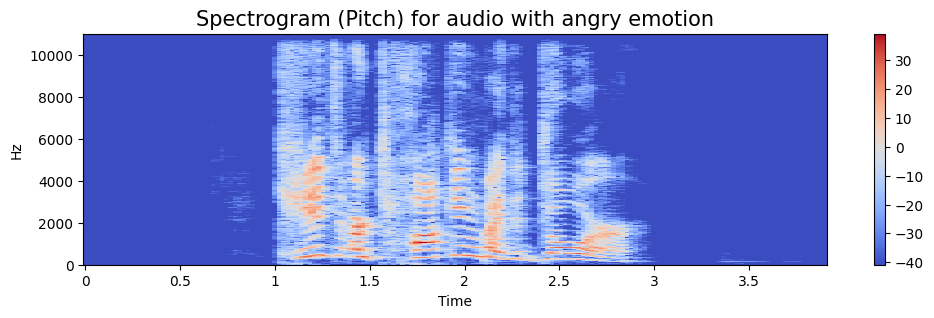

In [ ]:
all_emotions = df['Emotions'].unique()
for emotion in all_emotions:
    show(emotion)

### Comparitive MFCC waveform

In [ ]:
# generates line plot of mean pitch 

def amp_wave(emotion, gender):
    path = df[(df['Emotions'] == emotion) & (df['Gender'] == gender)]['Path'].iloc[1]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) 
    fig = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    fig = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    return fig

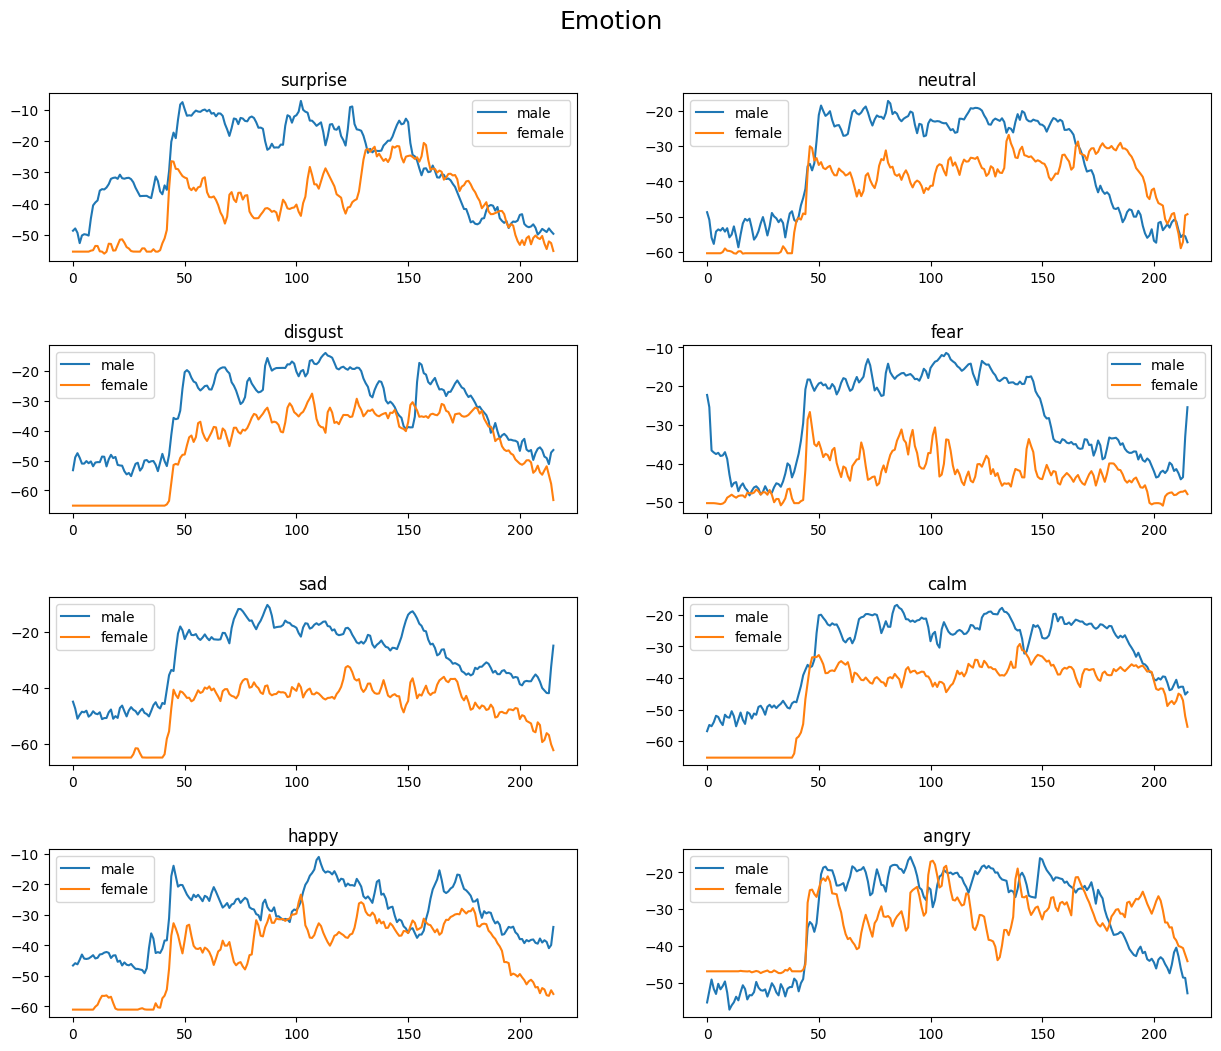

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Emotion", fontsize=18, y=0.95)
nrows = round(len(all_emotions)/2)

for i, emotion in enumerate(all_emotions):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, 2, i + 1)

    plt.plot(amp_wave(emotion, 0),  label='male')
    plt.plot(amp_wave(emotion, 1),  label='female')
    plt.legend()
    ax.set_title(emotion)


## Amplitude Envelope Feature


In [ ]:
def amplitude_envelope(emotion, frame_size, hop_len, visualise=True):
    path = np.array(df.Path[df.Emotions==emotion])[1]
    signal, sr = librosa.load(path)
    ae = np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_len)])
    
    frames = range(0, len(ae))
    times = librosa.frames_to_time(frames, hop_length = hop_len)
    
    if visualise == True:
        plt.figure(figsize=(10,6))
        librosa.display.waveshow(signal, alpha=0.5)
        plt.plot(times, ae, color='r')
        plt.title(emotion + " Amplitude Envelope")
        plt.show()
    
    return ae


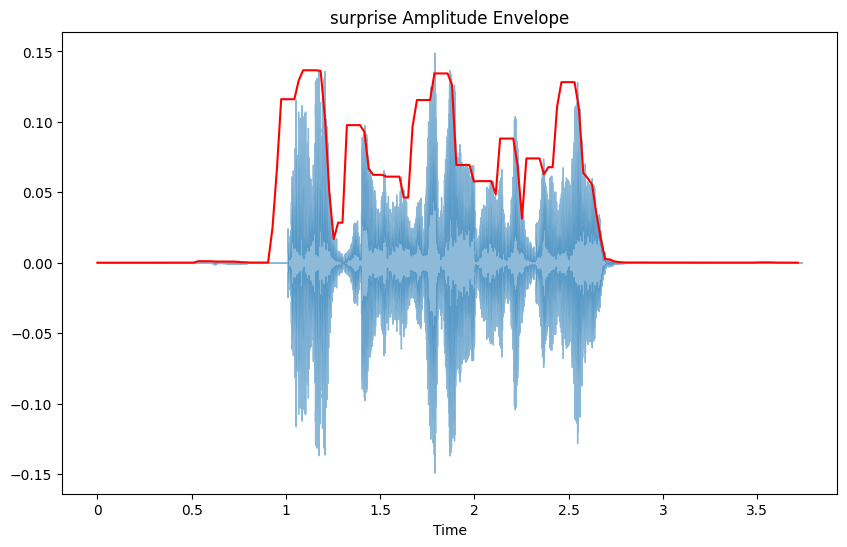

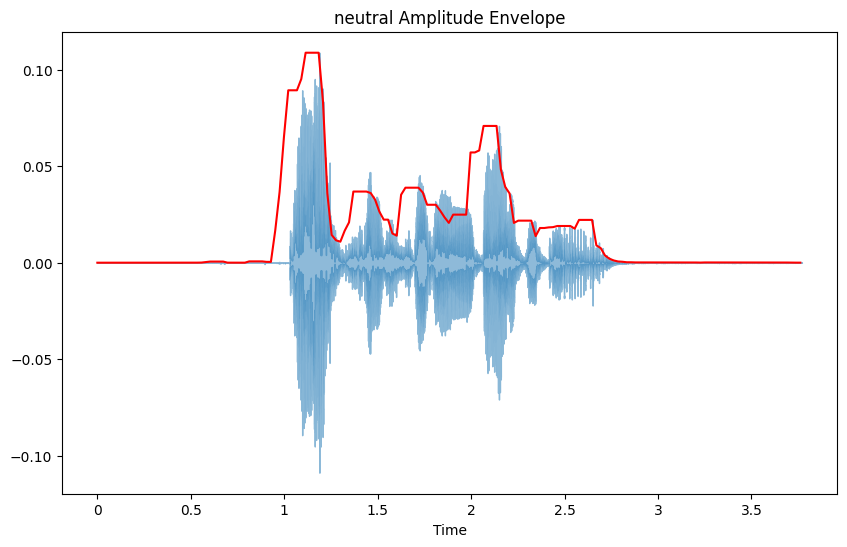

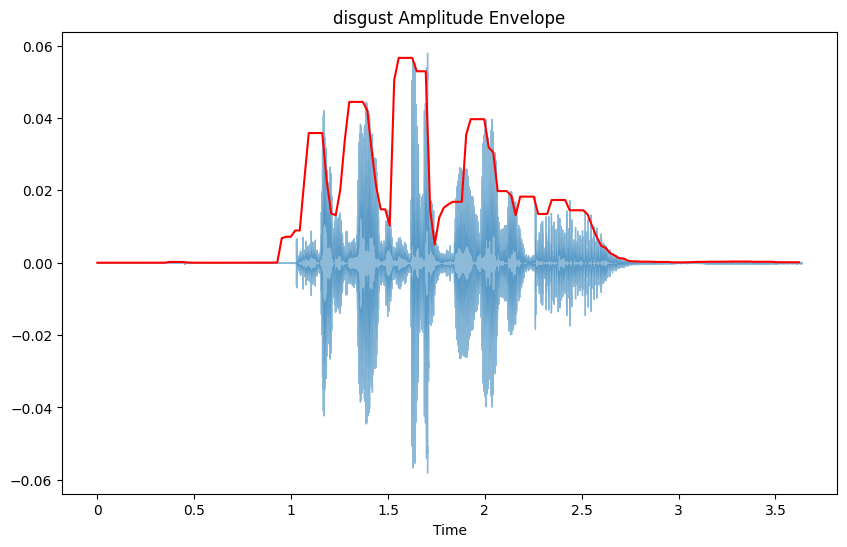

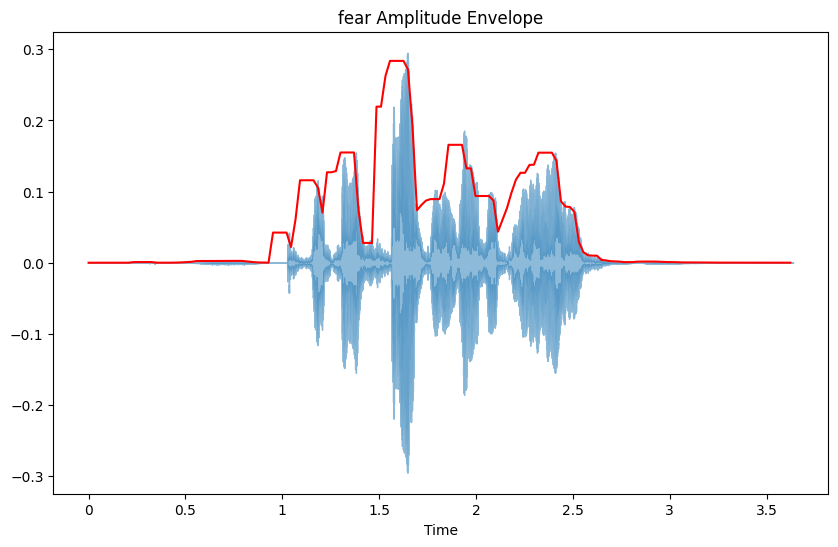

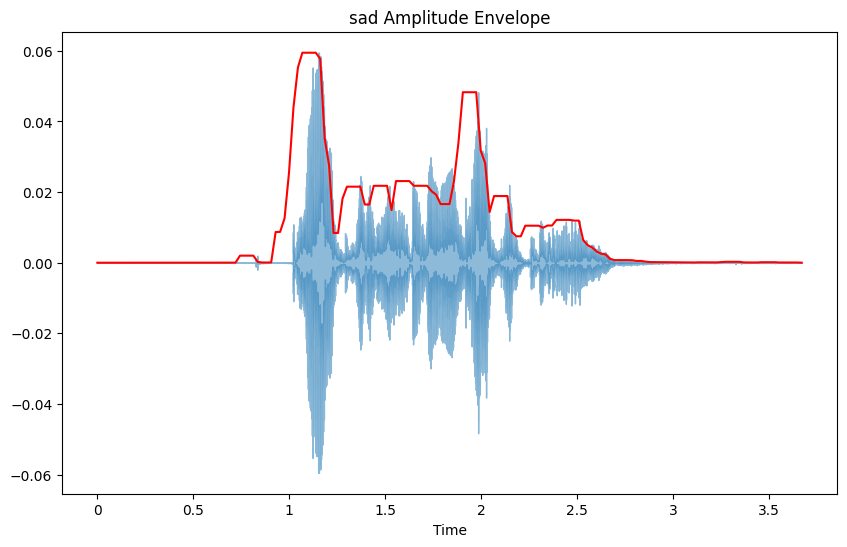

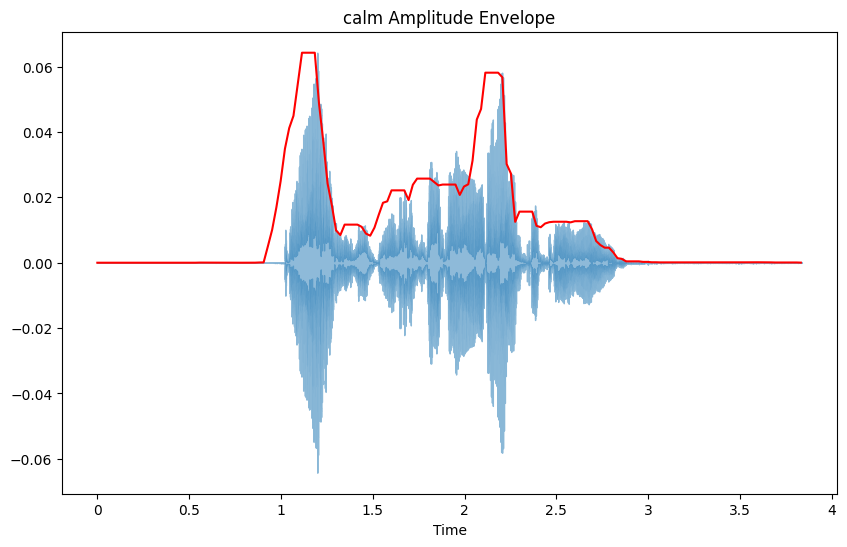

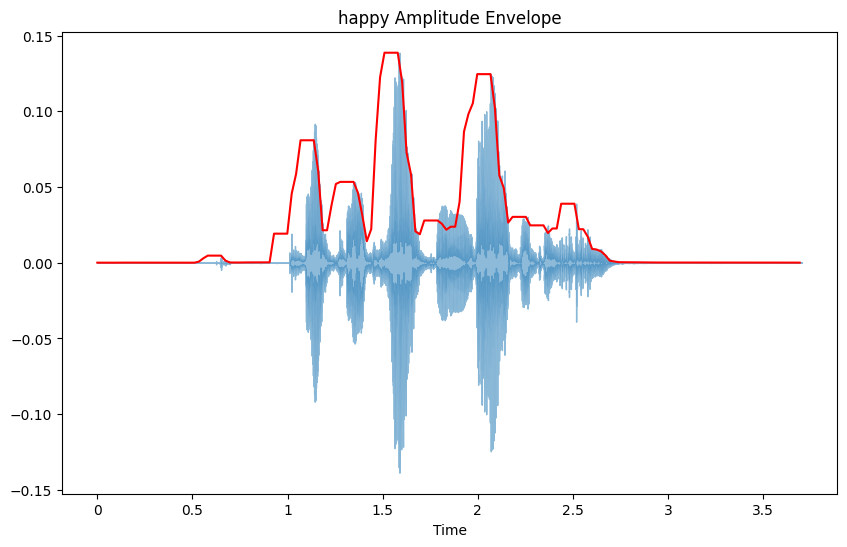

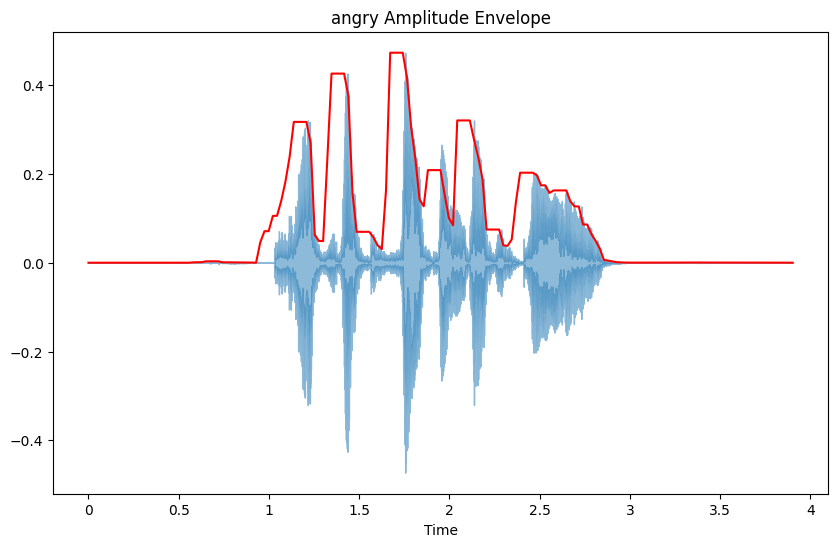

In [ ]:
all_emotions = df['Emotions'].unique()
for emotion in all_emotions:
    amplitude_envelope(emotion, frame_size=2048, hop_len=512)

Other metrics for amplitude
- root mean square energy
- zero crossing rate

And other metrics here 

- https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d
- https://jonathan-hui.medium.com/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9

In [20]:
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

# Data Augmentation

In [19]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

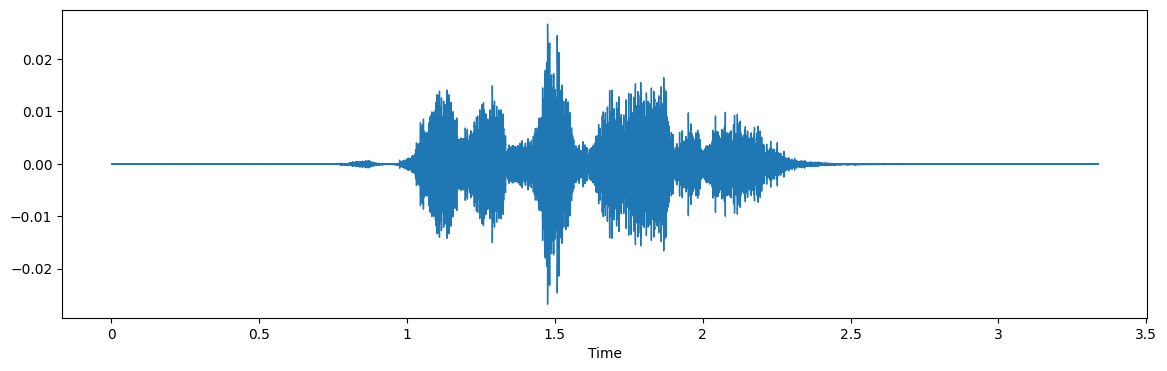

In [22]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [23]:

def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [24]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [25]:
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

In [26]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
1  0.323821  0.800868  0.823425  0.817045  0.823059  0.816318  0.694092   
2  0.188285  0.622130  0.699225  0.753333  0.721221  0.701736  0.682347   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.278777  0.757133  0.779765  0.741851  0.741822  0.748984  0.655474   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310903e-06  3.291511e-06   
1  0.676801  0.732272  0.762113  ...  7.157650e-05  7.492099e-05   
2  0.662826  0.686492  0.733961  ...  8.577343e-07  9.576414e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034951e-06   
4  0.657033  0.696922  0.733563  ...  1.176149e-05  1.165860e-05   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116492e-06  8.190282e-06  0.000007  0.000005   
1  7.403770e-05  7.334743e-05  7.584101e-05  7.553979e-05  0.000079  0.000075   
2  7.733593e-07  5.233101e-07  3.592793e-07  9.261689e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640183e-06  0.000011  0.000006   
4  1.124842e-05  1.199466e-05  1.711947e-05  1.508675e-05  0.000016  0.000011   

            161   labels  
0  4.245834e-07  neutral  
1  6.996039e-05  neutral  
2  7.753987e-08  neutral  
3  4.254087e-07  neutral  
4  5.304679e-06  neutral  

[5 rows x 163 columns]

# Data Preparation

In [27]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [33]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [34]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [35]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [36]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

# Modelling

In [37]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [38]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 5s 83ms/step - loss: 2.0230 - accuracy: 0.1889 - val_loss: 1.9577 - val_accuracy: 0.2380 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 4s 79ms/step - loss: 1.9771 - accuracy: 0.2000 - val_loss: 1.9051 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 4s 82ms/step - loss: 1.9313 - accuracy: 0.2259 - val_loss: 1.8321 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 4s 84ms/step - loss: 1.8833 - accuracy: 0.2469 - val_loss: 1.7863 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 4s 76ms/step - loss: 1.8496 - accuracy: 0.2642 - val_loss: 1.8119 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 4s 77ms/step - loss: 1.8212 - accuracy: 0.2827 - val_loss: 1.7504 - val_accuracy: 0.3463 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 4s 79ms/step - loss: 1.7

34/34 [==============================] - 0s 12ms/step - loss: 1.3432 - accuracy: 0.5935
Accuracy of our model on test data :  59.35184955596924 %


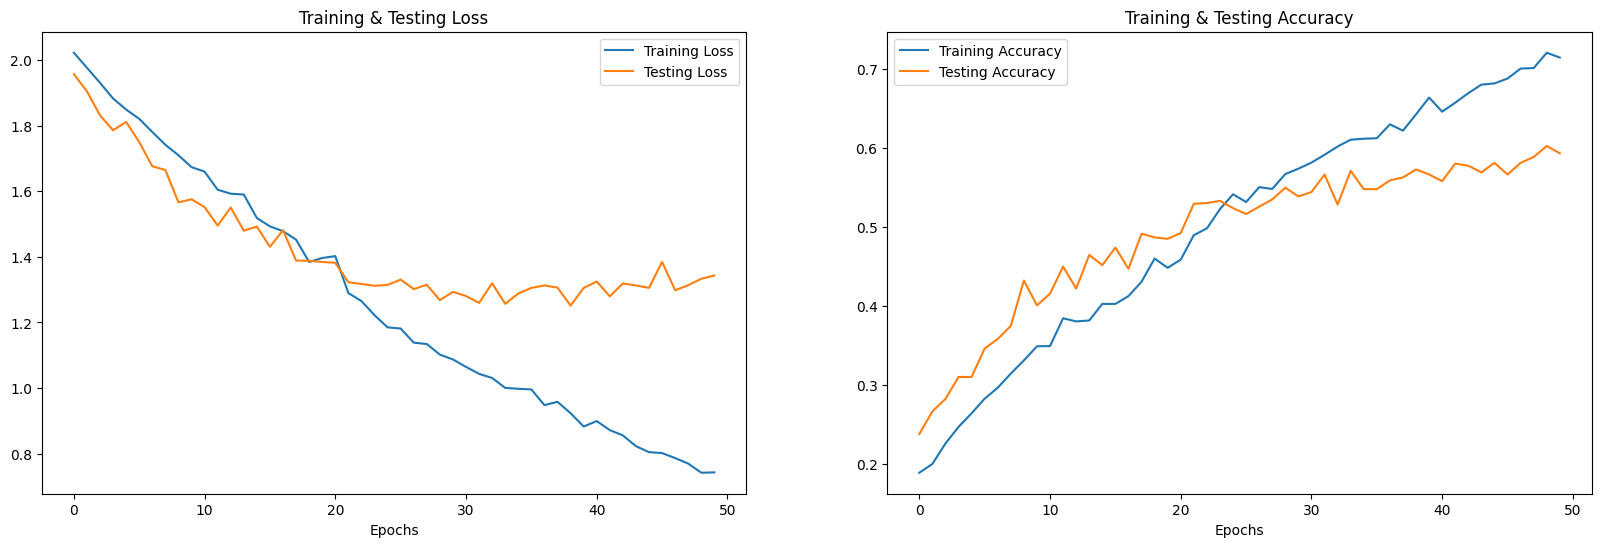

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [40]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 13ms/step


In [41]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1            angry         angry
2             fear          fear
3             calm          calm
4            angry         angry
5         surprise      surprise
6              sad          fear
7             fear         happy
8             fear          fear
9              sad           sad

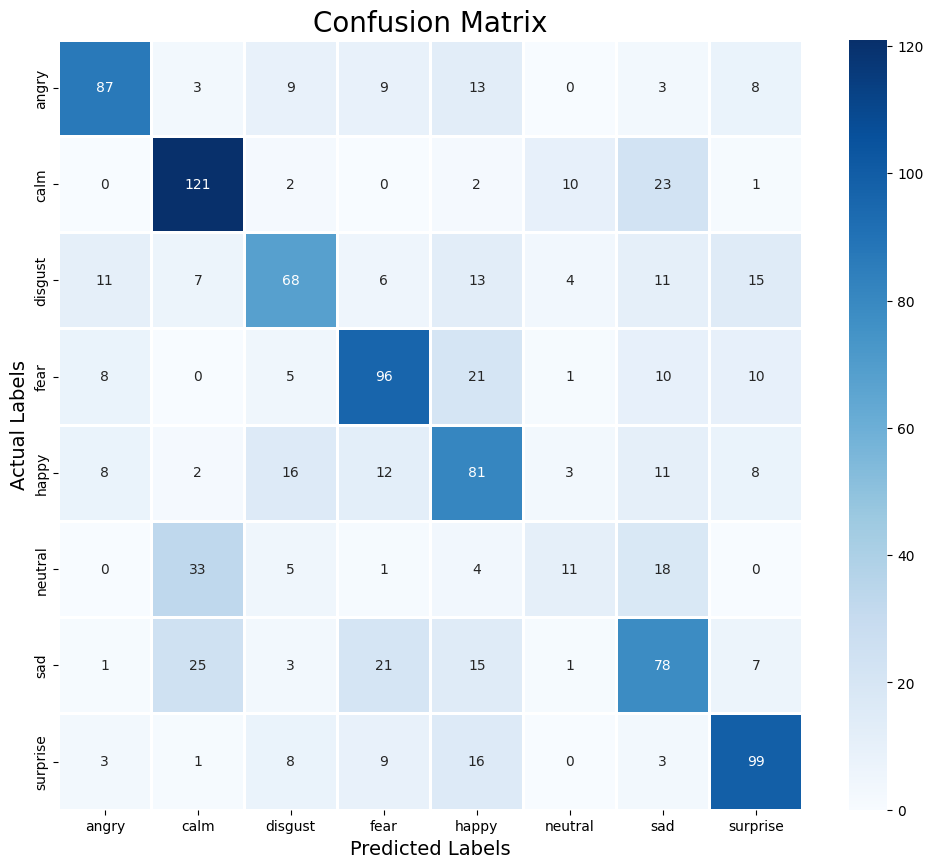

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.66      0.70       132
        calm       0.63      0.76      0.69       159
     disgust       0.59      0.50      0.54       135
        fear       0.62      0.64      0.63       151
       happy       0.49      0.57      0.53       141
     neutral       0.37      0.15      0.22        72
         sad       0.50      0.52      0.51       151
    surprise       0.67      0.71      0.69       139

    accuracy                           0.59      1080
   macro avg       0.58      0.56      0.56      1080
weighted avg       0.59      0.59      0.59      1080

